# Computation Speed Demo


Comparing compute time for:

compute type | data structure | packages
---|---|---
fortran-style looping | numpy array | numpy 
fortran-style looping sped up with numba | numpy array | numpy+numba 
vectorized computation | numpy array | numpy 
vectorized parallelized computation | dask array | numpy, dask, dask.distributed

## Set up

In [1]:
import numpy as np
import numba as nb
import dask.array as da
from dask.distributed import Client

from time import time as timer
import matplotlib.pyplot as plt

# xr just for creating dummy data 
import xarray as xr

In [2]:
data_dir = 'C://Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_china_03272023/'

## Dummy Data Creation

In [12]:
# define the spatial resolution of the data
# e.g. grids_per_degree=4 means 4 grid boxes per degree lat or lon (1/4 degree x 1/4 degree gridsize)
# enter dtype int here
grids_per_degree=8

# define number of chunks
# e.g. chunk_scale**2 total chunks, chunk_scale of 4 yield 16 chunks
# enter dtype int here, preferably in a multiple of the number of cores in your processor
chunk_scale=4

In [13]:
# grid and array 
gx=360
gy=180
nx=gx*grids_per_degree
ny=gy*grids_per_degree
nt=365

In [14]:
# function to create dummy data
def meanT_global_daily_dummy_data(nx,ny,nt,grids_per_degree,chunk_scale,tmax_xr,tmin_xr):
    # create lat lon grid centers based on dims
    lat=np.linspace(-90,90,ny+1).astype('float32') # location of grid box edges
    lat=(lat+abs((lat[-1]-lat[-2])/2))[:-1] # grid centers
    lon=np.linspace(-180,180,nx,endpoint=False).astype('float32') # grid edges
    lon=(lon+abs((lon[-1]-lon[-2])/2)) # grid centers  

    # create mean temperature 
    meanT=(tmax_xr+tmin_xr)/2    

    # expand onto a grid
    meanT_xr=meanT.expand_dims({'lon':lon,'lat':lat})

    # now create a numpy array with dims (x,y,t) as in pyaez tutorial notebooks
    meanT_np=meanT_xr.data

    # last create dask array (chunked numpy array)
    meanT_npda=da.from_array(meanT_np,chunks=(int(nx/chunk_scale),int(ny/chunk_scale),nt))

    return meanT_np, meanT_npda

In [15]:
# pull a single temperature timeseries from some local data files
# read data in as xarray dataArrays
tmax = xr.open_dataset(data_dir+'tmax_daily_8110.nc')['tmax'].isel(lat=300,lon=500).squeeze().reset_coords(['lat','lon'],drop=True)
tmin = xr.open_dataset(data_dir+'tmin_daily_8110.nc')['tmin'].isel(lat=300,lon=500).squeeze().reset_coords(['lat','lon'],drop=True)


In [16]:
# create data stored in 2 different ways
# the function outputs:
# numpy array with dims (nx,ny,nt)
# dask array (numpy array broken into chunk) with dims (nx,ny,nt)

meanT_np, meanT_npda = meanT_global_daily_dummy_data(nx,ny,nt,grids_per_degree,chunk_scale,tmax,tmin)

# look at the size in GB
meanT_npda

dask.array<array, shape=(2880, 1440, 365), dtype=float32, chunksize=(720, 360, 365), chunktype=numpy.ndarray>

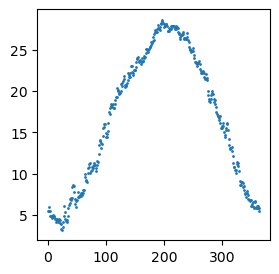

In [17]:
# plot a single grid cell timeseries
fig = plt.figure(figsize=(3,3))
plt.plot(meanT_np[0,0,:],marker='o',markersize=1,linewidth=0)

We've got daily mean temperature dummy data stored 2 different ways now:

- in a numpy array, dims (nx,ny,nt)
- in a dask array (numpy array broken into chunks), dims (nx,ny,nt)  

## Computations

Here we use a 4 different approaches for computing the following at each gridbox 
- annual mean T
- annual accumulated T
- warmest day
- coolest day

We'll demonstrate how vectorization and parallelization affect computation speed. 

Note: I purposefully picked simple calculations and functions supported by all packages so none of the demos error

### Fortran-style looping from numpy array

In [18]:
start=timer()

# pre-allocate arrays to store results
ann_meanT = np.empty((nx,ny)) 
ann_accT = np.empty((nx,ny))
day_warmest = np.empty((nx,ny))
day_coldest = np.empty((nx,ny)) 

# loop through each gridbox
for ix in range(nx): 
    for iy in range(ny):
        # single gridbox timeseries from numpy array 
        data_1D = meanT_np[ix,iy,:] 
        ann_meanT[ix,iy]=data_1D.mean()
        ann_accT[ix,iy]=data_1D.sum()
        day_warmest[ix,iy]=data_1D.argmax()+1
        day_coldest[ix,iy]=data_1D.argmin()+1       

tasktime = timer()-start
tasktime

54.04194498062134

In [19]:
del ann_meanT, ann_accT, day_warmest, day_coldest

on kerrie's windows desktop, grids_per_degree=8, (array size = 5.64GB):

the above takes ~51.5 seconds

### Fortran-style looping from numpy array sped up with numba

note: numba only works with a subset of numpy functions. Something as simple as np.median can cause errors and more complicated numpy functions like polynomial fitting aren't supported

In [20]:
# put everything inside a function 
start=timer()

@nb.jit(nopython=True)
def compute_stuff(nx,ny,data3D):
    # pre-allocate arrays to store results
    ann_meanT = np.empty((nx,ny)) 
    ann_accT = np.empty((nx,ny)) 
    day_warmest = np.empty((nx,ny)) 
    day_coldest = np.empty((nx,ny)) 

    for ix in range(nx): 
        for iy in range(ny):
            # single gridbox timeseries from numpy array 
            data_1D = data3D[ix,iy,:] 
            ann_meanT[ix,iy]=data_1D.mean()
            ann_accT[ix,iy]=data_1D.sum()
            day_warmest[ix,iy]=data_1D.argmax()+1
            day_coldest[ix,iy]=data_1D.argmin()+1 
            
    return ann_meanT, ann_accT, day_warmest, day_coldest       

ann_meanT, ann_accT, day_warmest, day_coldest = compute_stuff(nx,ny,meanT_np)

tasktime = timer()-start
tasktime

6.739246129989624

In [21]:
del ann_meanT, ann_accT, day_warmest, day_coldest

on kerrie's Windows desktop, grids_per_degree=8, (array size = 5.64GB):

Numba appears to be lightning fast, reducing a 51.5s fortran-style looped computation to ~6.5 seconds

BUT this still won't be faster than simply using vectorized numpy functions, as we will see next

Also, problems arise with numba for more complicated computations or use of functions that aren't supported by numba. In these cases, which is often, you can get no speed ups or even slow downs vs the fortran-style looping.

### Vectorized Computation with numpy

In [22]:
start=timer()

# no need to pre-allocate
# no loops, vectorize instead
# indicate computation on the time dimension by passing axis=2

ann_meanT=meanT_np.mean(axis=2)
ann_accT=meanT_np.sum(axis=2)
day_warmest=meanT_np.argmax(axis=2)+1
day_coldest=meanT_np.argmin(axis=2)+1       

tasktime = timer()-start
tasktime

4.933847188949585

In [23]:
del ann_meanT, ann_accT, day_warmest, day_coldest

on kerrie's Windows desktop, grids_per_degree=8, (array size = 5.64GB):

at ~5s, numpy vectorization results in slightly faster computation than fortran-style looping with numba

it also reduces the amount of code to 4 simple lines

additionally, numpy vectorization can apply to the entirety of the code, whereas numba loops can only speed up sections of simple code that is looped

### Vectorized Parallelized Computation with dask

In [24]:
# use all your computer's cores simulatenously, like a mini HPC cluster
# click on the cluster info expand arrow to get information about workers/threads/memory
# once you start a client in ipynb, you don't have to do it again unless you restart the kernel 
client=Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50006,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.69 GiB
Comm: tcp://127.0.0.1:50035,Total threads: 2
Dashboard: http://127.0.0.1:50036/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:50009,


In [25]:
start=timer()

# same code as for vectorized numpy, except using chunked data (meanT_npda) instead of meanT_np
# with minimal changes to the code we can parallelize the computations

# these lines are lazy, meaning they don't actually compute anything
# they simply store each task in a what's called a dask graph, for computation later
ann_meanT=meanT_npda.mean(axis=2)
ann_accT=meanT_npda.sum(axis=2)
day_warmest=meanT_npda.argmax(axis=2)+1
day_coldest=meanT_npda.argmin(axis=2)+1       

# when we want the results, we have to call compute
ann_meanT.compute()
ann_accT.compute()
day_warmest.compute()
day_coldest.compute()

tasktime = timer()-start
tasktime

2.886436939239502

In [26]:
del ann_meanT, ann_accT, day_warmest, day_coldest

on kerrie's Windows desktop, grids_per_degree=8, (array size = 5.64GB):

vectorized, parallelized computation is the fastest, requiring only ~3 seconds


- implementation of vectorized computation across the entire pyaez will provide the biggest speed gain
- implementation of parallelized lazy computation on the heaviest comps will provide additional pyaez speed gains
- implementation of additional parallelized lazy comps outside of the heaviest comps will slow pyaez down a little bit but will allow input of much larger datasets without running out of memory

## Caveats

We will only get dask speed gains for bigger data due to the overhead of the parallelization (see table below comparing times for different sized input data)

grids_per_degree| array size | nchunks | fortran-style python | fortran-style python +numba | vectorized python | vectorized parallelized (dask)
---|---|---|---|---|---|---
2 | 360 MB | 16 | 3s | 1.5s | 0.3s | 1s   
4 | 1.41 GB | 16 | 12.5s | 2.5s | 1.25s | 2s
8 | 5.64 GB | 16 | 51.5s | 6.5s | 5s | 3.75s
16 | 22.56 GB | 16 | 202.5s | 22.5s | 20s | 11s
16 | 22.56 GB | 64 | n/a | n/a | n/a | 10s
16 | 22.56 GB | 144 | n/a | n/a | n/a | 10s


## Recommendation

- eliminate use of loops and numba
- implement vectorization throughout the entire code
- implement dask for the heaviest computations
- later, implement more dask to allow for memory improvements